# Assignment - 15

Usage of eager execution and TFRecord in Implementing DavidNet

Additionally, input pipeline optimization is carried out to improve on performance.

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

!nvidia-smi

Tue Nov 19 00:20:09 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 430.50       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 107...  Off  | 00000000:08:00.0  On |                  N/A |
| 25%   56C    P0    47W / 180W |    562MiB /  8117MiB |      2%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import numpy as np
import time, math
from tqdm import tqdm_notebook as tqdm

if IN_COLAB: 
    %tensorflow_version 1.x

import tensorflow as tf
import tensorflow.contrib.eager as tfe

/home/sambit/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sambit/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sambit/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sambit/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dty

## Enabling Eager Execution

In [3]:
tf.enable_eager_execution()


## Hyperparameters

In [4]:
BATCH_SIZE = 512 #@param {type:"integer"}
MOMENTUM = 0.9 #@param {type:"number"}
LEARNING_RATE = 0.4 #@param {type:"number"}
WEIGHT_DECAY = 5e-4 #@param {type:"number"}
EPOCHS = 24 #@param {type:"integer"}

## Parameter Initialization Like PyTorch

Initialization function now returns a NumPy array for eager execution. 

In [5]:
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
    fan = np.prod(shape[:-1])
    bound = 1 / math.sqrt(fan)
    return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype).numpy()

## Model

All models are activated with `dynamic=True` in the `super()` class ensuring the model has been enabled for eager execution 

In [6]:
class ConvBN(tf.keras.Model):
    def __init__(self, c_out):
        super(ConvBN, self).__init__(dynamic=True)
        self.lcount = 1
        self.conv = tf.keras.layers.Conv2D(filters=c_out, kernel_size=3, padding="SAME", 
                                           kernel_initializer=init_pytorch, use_bias=False, dynamic=True, 
                                           name="Conv2D_"+str(self.lcount))
        self.lcount+=1
        self.bn   = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, dynamic=True, 
                                                      name="BatchNormalization_"+str(self.lcount))

    def call(self, inputs):
        return tf.nn.relu(self.bn(self.conv(inputs)))

In [7]:
class ResBlk(tf.keras.Model):
    def __init__(self, c_out, pool, res = False):
        super(ResBlk, self).__init__(dynamic=True)
        self.conv_bn = ConvBN(c_out)
        self.pool = pool
        self.res = res
        if self.res:
            self.res1 = ConvBN(c_out)
            self.res2 = ConvBN(c_out)

    def call(self, inputs):
        h = self.pool(self.conv_bn(inputs))
        if self.res:
            h = h + self.res2(self.res1(h))
        return h

In [8]:
class DavidNet(tf.keras.Model):
    def __init__(self, c=64, weight=0.125):
        super(DavidNet, self).__init__(dynamic=True)
        pool = tf.keras.layers.MaxPooling2D(dynamic=True)
        self.init_conv_bn = ConvBN(c)
        self.blk1 = ResBlk(c*2, pool, res = True)
        self.blk2 = ResBlk(c*4, pool)
        self.blk3 = ResBlk(c*8, pool, res = True)
        self.pool = tf.keras.layers.GlobalMaxPool2D(dynamic=True)
        self.linear = tf.keras.layers.Dense(10, kernel_initializer=init_pytorch, use_bias=False, dynamic=True)
        self.weight = weight

    def call(self, x, y):
        h = self.pool(self.blk3(self.blk2(self.blk1(self.init_conv_bn(x)))))
        h = self.linear(h) * self.weight
        ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h, labels=y)
        loss = tf.reduce_sum(ce)
        outval = tf.argmax(h, axis = 1)
        correct = tf.reduce_sum(tf.cast(tf.math.equal(outval, y), tf.float32))
        return loss, correct.numpy(), outval.numpy()

## TF Record Dataset

1. Build a dataset builder and download from the TensorFlow repository and not Keras (idea is to work on files instead of loaded memory as ndarray)
2. Load the CIFAR-10 data from the NFRecord files separating test and train set
3. Read each record as tuple of image and label Tensors
4. Add normalization, padding and data augmentation methods in the Tensor format to ensure they can be computed on demand
5. Add batching and prefetch for subsequent iteration and data read

Till actual iteration begins data is not accessible or loaded (other than prefetched data). Hence, all the computation is carried out in the delayed execution mode. 

### Input Pipelining

The input to the model are pipelined and parallelized by letting TensorFlow autotune the parameters. 

The Ryzen-5 processor with 6 cores and 12 threads are available to parallelize the input reads.

In [9]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import tensorflow_datasets as tfds
import tensorflow.contrib.image as tfi

from tensorflow.data import  TFRecordDataset
from glob import glob
from tensorflow_datasets.core import DatasetBuilder

import os

tf.enable_eager_execution()
assert tf.executing_eagerly()

train_mean = (0.4914, 0.4822, 0.4465)
train_std  = (0.2023, 0.1994, 0.2010)
normalize = lambda x: (tf.cast(x, tf.float32)/255 - train_mean) / train_std

random_crop = lambda x,n: tf.random_crop(x, [n, n, 3])
random_flip_left_right = lambda x: tf.image.random_flip_left_right(x)
pad = lambda x, n: tf.pad(x, [[n, n], [n, n], [0, 0]], mode='reflect')
random_rotate = lambda x, n: tf.contrib.image.rotate(x, (np.random.rand()-0.5)*math.pi/180*n)
def cutout(x, si, sj):
    ci = tf.random.uniform((1,), 0, x.shape[0] - si - 1, dtype=tf.int32)[0]
    cj = tf.random.uniform((1,), 0, x.shape[1] - sj - 1, dtype=tf.int32)[0]
    idx = [tf.range(ci, si), tf.range(cj, sj)]
    val = tf.zeros((si, sj, 3))
    tf.tensor_scatter_update(x, idx, val)
    return x
image_augment = lambda x: cutout(normalize(random_rotate(random_crop(random_flip_left_right(pad(x, 4)), 32), 10)), 8, 8)

def parse_fn(example):
    example_fmt = {
        'image': tf.io.FixedLenFeature((), tf.string, ""),
        'label': tf.io.FixedLenFeature((), tf.int64, -1)
    }
    parsed = tf.parse_example(example, example_fmt)
    images = tf.map_fn(tf.io.decode_image, parsed['image'], dtype=tf.uint8)
    images = tf.reshape(images, [-1, 32, 32, 3])
    return (images, parsed['label'])

def make_dataset(path, transform, nfile, dtype=tf.float32, batch=BATCH_SIZE, shuffle=False):
    files = tf.data.Dataset.list_files(path)
    dataset = files.interleave(tf.data.TFRecordDataset, cycle_length=nfile, 
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch)
    if shuffle:
        dataset = dataset.shuffle(batch)
    func = lambda x: (tf.map_fn(transform, x[0], dtype=dtype), x[1])    
    dataset = dataset.map(map_func=lambda a: func(parse_fn(a)), 
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

cifar10_bldr = tfds.builder("cifar10")
cifar10_bldr.download_and_prepare()
cifar10_info = cifar10_bldr.info
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

name = cifar10_info.name
vrsn = '{}'.format(cifar10_info.version)

len_train, len_test = cifar10_info.splits['train'].num_examples, cifar10_info.splits['test'].num_examples

cifar10_bldr.download_and_prepare()

train_path = os.path.join(os.getenv("HOME"), 'tensorflow_datasets', name, vrsn, '*train.tfrecord*')
test_path  = os.path.join(os.getenv("HOME"), 'tensorflow_datasets', name, vrsn, '*test.tfrecord*')

train_fn = glob(train_path)
test_fn  = glob(test_path)

train_tfr, test_tfr = make_dataset(train_fn, image_augment, 10), make_dataset(test_fn, normalize, 1)

## Model Initialization

Models is initialized with global step initialized so that the lr_schedule can be configured on the global step. Global step though is a Tensor is returned as an integer as part of eager execution. 

In [10]:
model = DavidNet()

assert model.run_eagerly, "Eager execution is not enabled for the model"

batches_per_epoch = len_train//BATCH_SIZE + 1

lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//5, EPOCHS], [0, LEARNING_RATE, 0])[0]
global_step = tf.train.get_or_create_global_step()
lr_func = lambda: lr_schedule(global_step.numpy()/batches_per_epoch)/BATCH_SIZE
opt = tf.train.MomentumOptimizer(lr_func, momentum=MOMENTUM, use_nesterov=True)


## Training

The fit or fit_generator calls are not used for training. 

1. GradientTape records the forward pass gradient computations
2. In the back propagation step the recorded values are used to update the trainable parameters. 

Final data is printed in a formatted output. TQDM module provides a nice progress bar indication.

Introduction of the TFRecord has increased the total time of training. With parallelization introduced the values can be reduced later. 

**Single threaded input**

Accuracy: 92.93%

Time: 1064.7s

**With input pipeline optimization with weights backup**

Accuracy: 92.69%

Time: 731.1s

In [11]:
from tensorflow.python.eager.profiler import Profiler, start, stop, save
import os

t = time.time()

try:
    start()
    test_set  = test_tfr.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    train_set = train_tfr.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    max_acc = 0.0
    for epoch in range(EPOCHS):
        train_loss = test_loss = train_acc = test_acc = 0.0
        tf.keras.backend.set_learning_phase(1)
        for (x, y) in tqdm(train_set):
            with tf.GradientTape() as tape:
                loss, correct, _ = model(x, y)

            var = model.trainable_variables
            grads = tape.gradient(loss, var)
            for g, v in zip(grads, var):
                g += v * WEIGHT_DECAY * BATCH_SIZE
            opt.apply_gradients(zip(grads, var), global_step=global_step)

            train_loss += loss.numpy()
            train_acc += correct

        tf.keras.backend.set_learning_phase(0)
        for (x, y) in test_set:
            loss, correct, _ = model(x, y)
            test_loss += loss.numpy()
            test_acc += correct

        train_loss /= len_train
        train_acc  /= len_train
        test_loss  /= len_test
        test_acc   /= len_test

        print('epoch:', epoch+1, 
              'lr:{0:.4f}'.format(lr_schedule(epoch+1)), 
              'train loss: {0:.4f}'.format(train_loss), 
              'train acc: {0:.4f}'.format(train_acc), 
              'val loss: {0:.4f}'.format(test_loss), 
              'val acc: {0:.4f}'.format(test_acc), 
              'time:{0:5.1f}'.format(time.time() - t))

        if test_acc > max_acc:
            max_acc = test_acc
            model_path = 'weights.{0:.4f}-{1:03d}.h5'.format(test_acc, epoch)
            print("Writing model path: ", model_path)
            model.save_weights(model_path)

        if epoch == 10:
            profile_res = stop()
            save('logs', profile_res)

except Exception as e: 
    print(e)
    stop()
        



epoch: 1 lr:0.0800 train loss: 1.6116 train acc: 0.4201 val loss: 1.1646 val acc: 0.5867 time: 34.7
Writing model path:  weights.0.5867-000.h5



epoch: 2 lr:0.1600 train loss: 0.9059 train acc: 0.6781 val loss: 0.8127 val acc: 0.7184 time: 64.0
Writing model path:  weights.0.7184-001.h5



epoch: 3 lr:0.2400 train loss: 0.6944 train acc: 0.7582 val loss: 0.8753 val acc: 0.7134 time: 93.5



epoch: 4 lr:0.3200 train loss: 0.5907 train acc: 0.7963 val loss: 0.9738 val acc: 0.6992 time:122.5



epoch: 5 lr:0.4000 train loss: 0.5300 train acc: 0.8162 val loss: 0.5950 val acc: 0.7980 time:152.3
Writing model path:  weights.0.7980-004.h5



epoch: 6 lr:0.3789 train loss: 0.4415 train acc: 0.8473 val loss: 0.5054 val acc: 0.8267 time:181.7
Writing model path:  weights.0.8267-005.h5



epoch: 7 lr:0.3579 train loss: 0.3624 train acc: 0.8743 val loss: 0.4894 val acc: 0.8375 time:211.3
Writing model path:  weights.0.8375-006.h5



epoch: 8 lr:0.3368 train loss: 0.3052 train acc: 0.8938 val loss: 0.4665 val acc: 0.8488 time:240.5
Writing model path:  weights.0.8488-007.h5



epoch: 9 lr:0.3158 train loss: 0.2741 train acc: 0.9050 val loss: 0.4426 val acc: 0.8531 time:269.8
Writing model path:  weights.0.8531-008.h5



epoch: 10 lr:0.2947 train loss: 0.2421 train acc: 0.9156 val loss: 0.3741 val acc: 0.8788 time:299.2
Writing model path:  weights.0.8788-009.h5



epoch: 11 lr:0.2737 train loss: 0.2152 train acc: 0.9265 val loss: 0.3972 val acc: 0.8692 time:328.5



epoch: 12 lr:0.2526 train loss: 0.1883 train acc: 0.9354 val loss: 0.3373 val acc: 0.8904 time:375.2
Writing model path:  weights.0.8904-011.h5



epoch: 13 lr:0.2316 train loss: 0.1650 train acc: 0.9426 val loss: 0.3345 val acc: 0.8909 time:404.0
Writing model path:  weights.0.8909-012.h5



epoch: 14 lr:0.2105 train loss: 0.1483 train acc: 0.9492 val loss: 0.3618 val acc: 0.8851 time:432.9



epoch: 15 lr:0.1895 train loss: 0.1304 train acc: 0.9549 val loss: 0.3310 val acc: 0.8969 time:461.8
Writing model path:  weights.0.8969-014.h5



epoch: 16 lr:0.1684 train loss: 0.1138 train acc: 0.9617 val loss: 0.3295 val acc: 0.9022 time:491.6
Writing model path:  weights.0.9022-015.h5



epoch: 17 lr:0.1474 train loss: 0.0984 train acc: 0.9656 val loss: 0.3018 val acc: 0.9085 time:520.7
Writing model path:  weights.0.9085-016.h5



epoch: 18 lr:0.1263 train loss: 0.0864 train acc: 0.9718 val loss: 0.3084 val acc: 0.9073 time:550.7



epoch: 19 lr:0.1053 train loss: 0.0740 train acc: 0.9764 val loss: 0.2957 val acc: 0.9138 time:579.8
Writing model path:  weights.0.9138-018.h5



epoch: 20 lr:0.0842 train loss: 0.0624 train acc: 0.9796 val loss: 0.2792 val acc: 0.9179 time:609.7
Writing model path:  weights.0.9179-019.h5



epoch: 21 lr:0.0632 train loss: 0.0565 train acc: 0.9818 val loss: 0.2724 val acc: 0.9198 time:638.9
Writing model path:  weights.0.9198-020.h5



epoch: 22 lr:0.0421 train loss: 0.0476 train acc: 0.9854 val loss: 0.2676 val acc: 0.9213 time:668.2
Writing model path:  weights.0.9213-021.h5



epoch: 23 lr:0.0211 train loss: 0.0405 train acc: 0.9884 val loss: 0.2599 val acc: 0.9230 time:697.6
Writing model path:  weights.0.9230-022.h5



epoch: 24 lr:0.0000 train loss: 0.0380 train acc: 0.9891 val loss: 0.2556 val acc: 0.9254 time:727.1
Writing model path:  weights.0.9254-023.h5


## Loading the Model

Load the model that provides the best results. Extracting the model, ground truth and results from the model.

In [12]:
if IN_COLAB:
    !git clone https://github.com/sambitdash/EVA-2-Group.git
    !cp EVA-2-Group/Session-15/weights.h5 .

In [13]:
model.load_weights('weights.h5')

results = []

for (x, y) in test_set:
    loss, correct, res = model(x, y)
    results.append(res)
    
results = np.concatenate(results)

for (x, y) in make_dataset(test_fn, lambda x: x, 1, dtype=tf.uint8, batch=len_test): pass
X, Y = x.numpy(), y.numpy()

## Plotting Method for the Library

In [14]:
from matplotlib import pyplot as plt
%matplotlib inline


def plot_image(nx, ny, X, Y, results=None, ptype='random', pclass=-1):
    l = len(Y)
    idx = np.zeros((nx, ny), dtype='int')
    title = ""
    if ptype == 'random': 
        idx = np.random.randint(0, len(Y), size=(nx, ny))
        title = "Random images"
    elif ptype == 'class':
        if pclass < 0:
            raise Exception("Specific class should be defined.")
        title = "{0:s} class images".format(cifar10_classes[pclass].capitalize())
        k = 0
        for i in range(nx):
            for j in range(ny):
                while Y[k] != pclass: k+=1
                idx[i, j] = k
                k += 1
    elif ptype == 'missed':
        if results is None:
            raise Exception("results cannot be None for misclassified images")
        
        if pclass < 0 :
            title = "Misclassified images"
        else: 
            title = "Misclassified {0:s} class images".format(cifar10_classes[pclass].capitalize())
        
        k = 0
        for i in range(nx):
            if k >= l:
                break
            for j in range(ny):
                if pclass == -1: 
                    while (Y[k] == results[k]): k+=1
                else:
                    while Y[k] != pclass or (Y[k] == results[k]): k+=1
                if k >= l:
                    break
                idx[i, j] = k
                k += 1

    fig, ax = plt.subplots(nx, ny, figsize = (3*nx, 3*ny))
    fig.suptitle(title)
    fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
    
    for (ix, iy) in [(i, j) for i in range(nx) for j in range(ny)]:
        ii = idx[ix, iy]
        ax[ix, iy].imshow(X[ii])
        ax[ix, iy].axis('off')
        acls = cifar10_classes[Y[ii]]
        if results is None:
            pcls = "none"
        else:
            pcls = cifar10_classes[results[ii]]
        ax[ix, iy].set_title('%d A: %s P: %s' % (ii, acls, pcls))

## Results

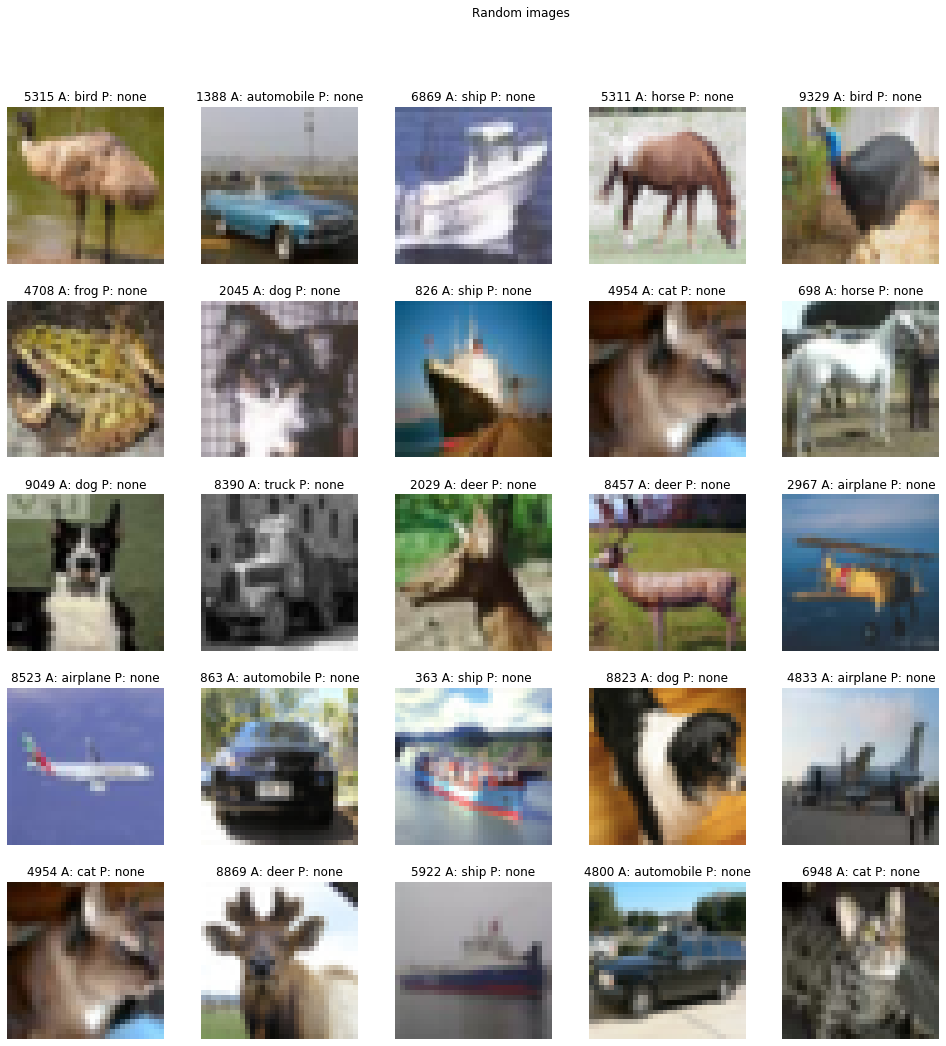

In [15]:
plot_image(5, 5, X, Y)

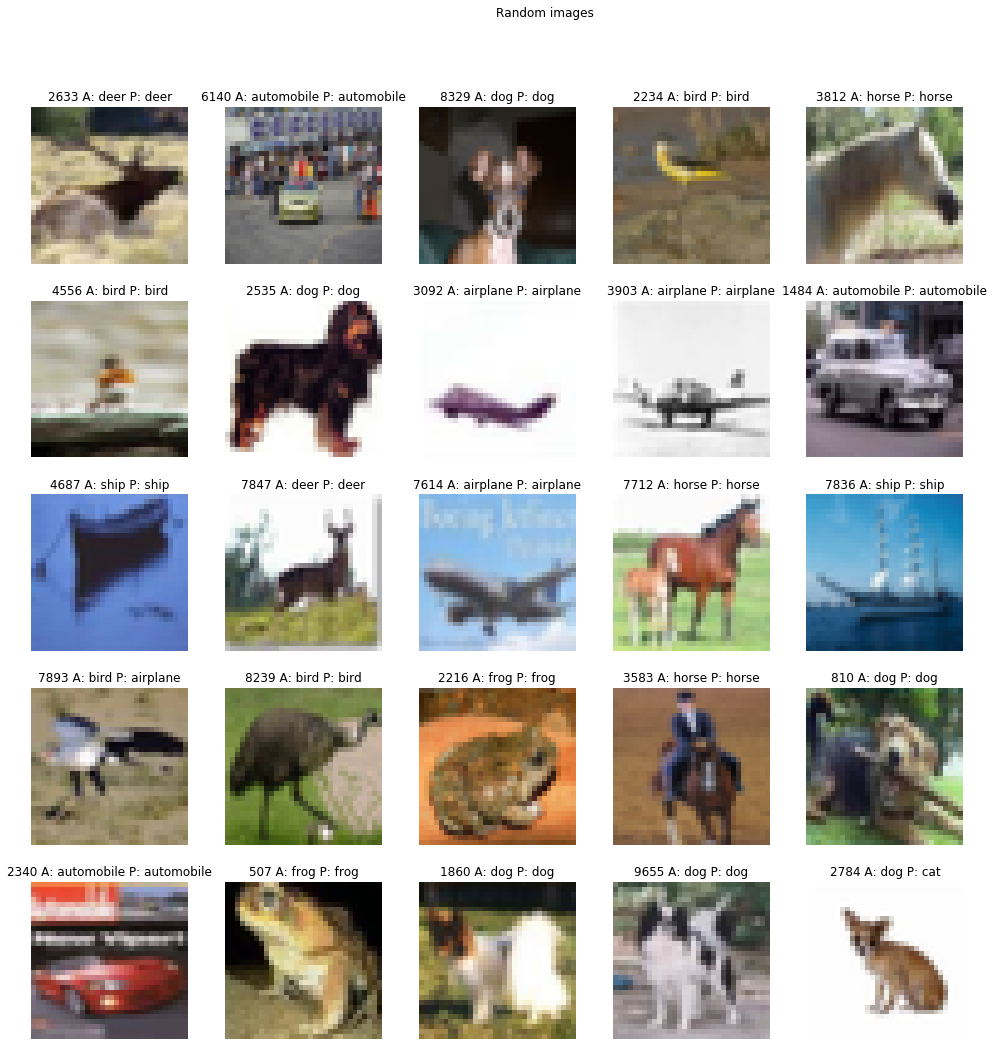

In [16]:
plot_image(5, 5, X, Y, results)

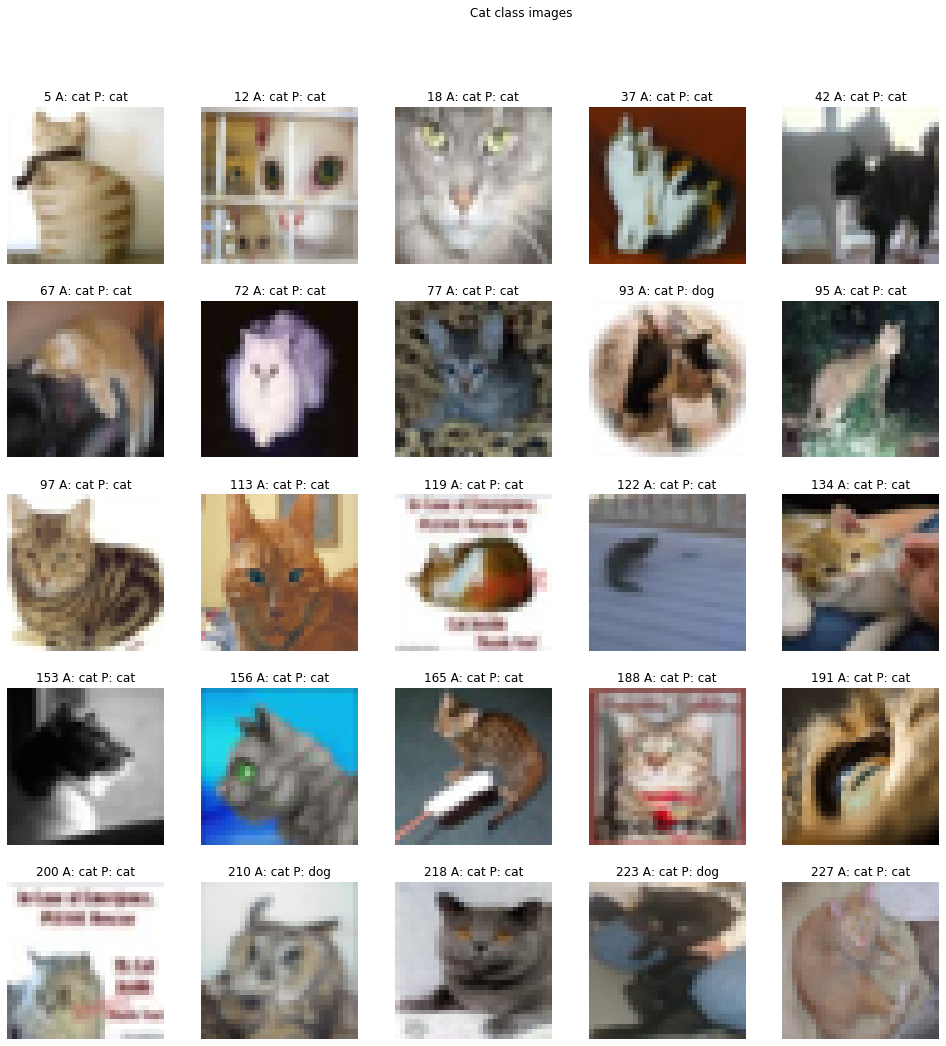

In [17]:
plot_image(5, 5, X, Y, results, ptype='class', pclass=3)

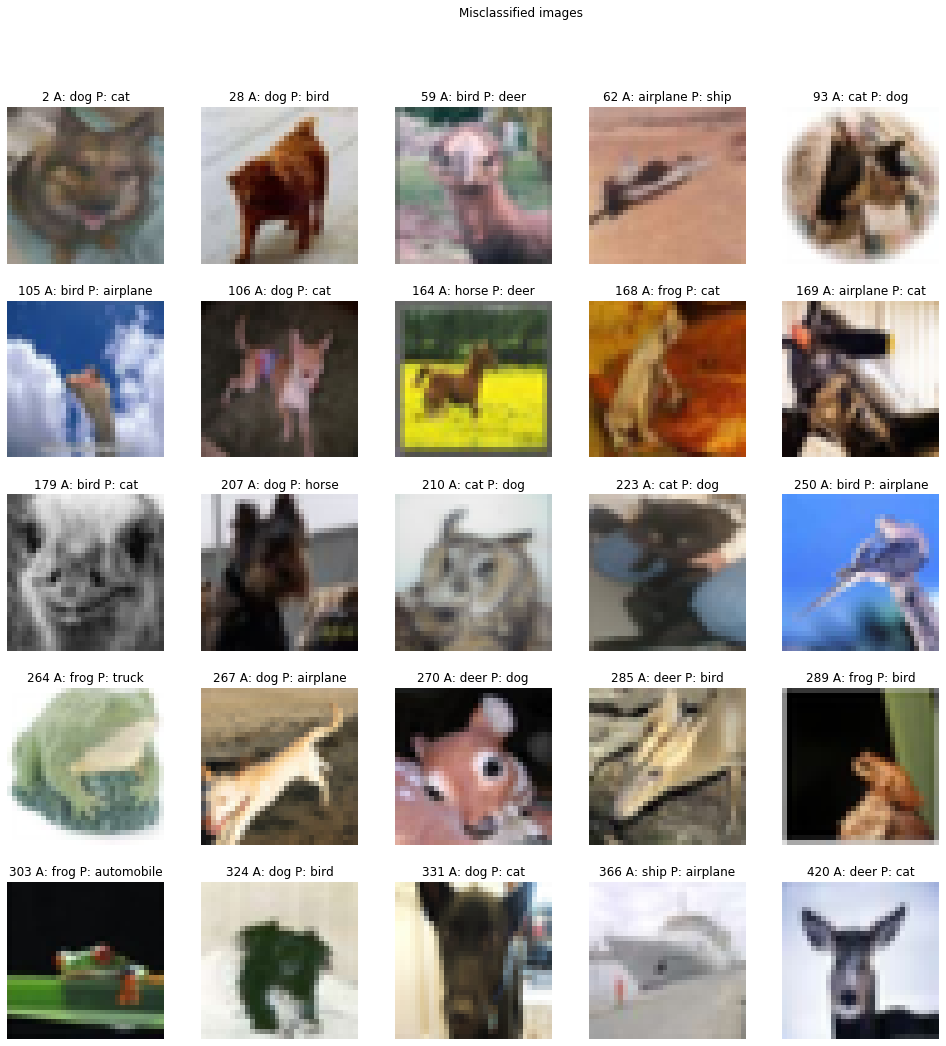

In [18]:
plot_image(5, 5, X, Y, results, ptype='missed')

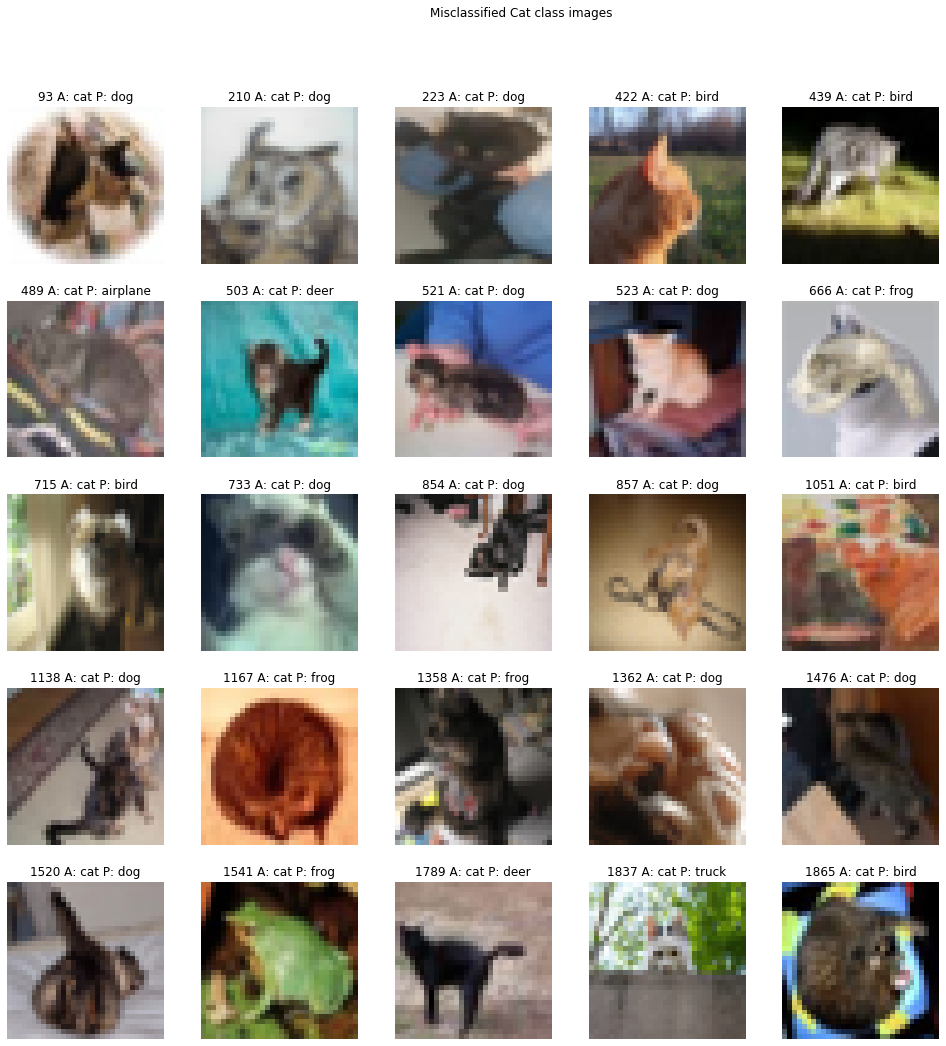

In [19]:
plot_image(5, 5, X, Y, results, ptype='missed', pclass=3)